## Predição da Safra de 2020 | SciCrop

<br>

Neste Notebook será utilizado Machine Learning, mais especificamente Classificação* para prever o dano na safra de 2020 baseados nas informações abaixo:

<br><br>

*Foi escolhido a Classificação porque o resultado a ser previsto é categórico (1,2,3) e não quantitativo, como por exemplo, o número de insetos.

<br>

| Variável                 | Descrição                                                    |
| ------------------------ | ------------------------------------------------------------ |
| Identificador_Agricultor | IDENTIFICADOR DO CLIENTE                                     |
| Estimativa_de_Insetos    | Estimativa de insetos por M²                                 |
| Tipo_de_Cultivo          | Classificação do tipo de cultivo (0,1)                       |
| Tipo_de_Solo             | Classificação do tipo de solo (0,1)                          |
| Categoria_Pesticida      | Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando) |
| Doses_Semana             | Número de doses por semana                                   |
| Semanas_Utilizando       | Número de semanas Utilizada                                  |
| Semanas_Sem_Uso          | Número de semanas sem utilizar                               |
| Temporada                | Temporada Climática (1,2,3)                                  |
| dano_na_plantacao        | Variável de Predição - Dano no Cultivo (0=Sem Danos, 1=Danos causados por outros motivos, 2=Danos gerados pelos pesticidas) |


Este notebook está dividido nas seguintes partes:

<br>
    
    1. Setup do environment
    2. EDA (Exploratory Data Analysis)
    3. Limpando e organizando os dados (caso seja necessário)
    4. Criação do Modelo de Predição
    5. Tunando os Hiperparâmetros
    6. Métricas de Avaliação
    7. Visualizando Category Importance
    8. Visualizando a predição 

### 1. Setup do environment

In [2]:
# Ferramentas básicas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

%matplotlib inline

In [ ]:
# Modelos

In [ ]:
# Avalição

In [243]:
# Importando os dados
Safra_18_19 = pd.read_csv('Safra_2018-2019.csv', index_col = 0)
Safra_20    = pd.read_csv('Safra_2020.csv', index_col = 0)

# Visualizando a tabela
Safra_18_19.columns

Index(['Identificador_Agricultor', 'Estimativa_de_Insetos', 'Tipo_de_Cultivo',
       'Tipo_de_Solo', 'Categoria_Pesticida', 'Doses_Semana',
       'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Temporada',
       'dano_na_plantacao'],
      dtype='object')

### 2. EDA ( Exploratory Data Analysis)

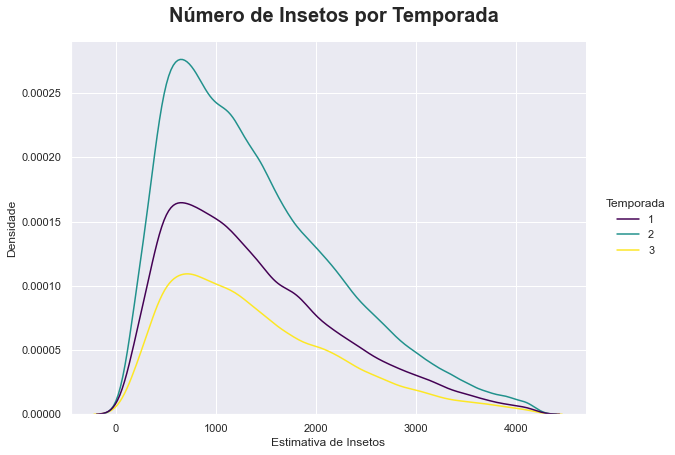

In [176]:
# Visualizando a correlação entre o número de insetos e a estação do ano
sns.set_style('whitegrid')

plot = sns.displot( x        = Safra_18_19.Estimativa_de_Insetos,
                    hue      = Safra_18_19.Temporada, 
                    kind     = 'kde',
                    height   = 6, 
                    aspect   = 11.7/8.27,
                    palette  = 'viridis')

plot.fig.suptitle('Número de Insetos por Temporada',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Estimativa de Insetos',
         ylabel = 'Densidade')

plt.show()

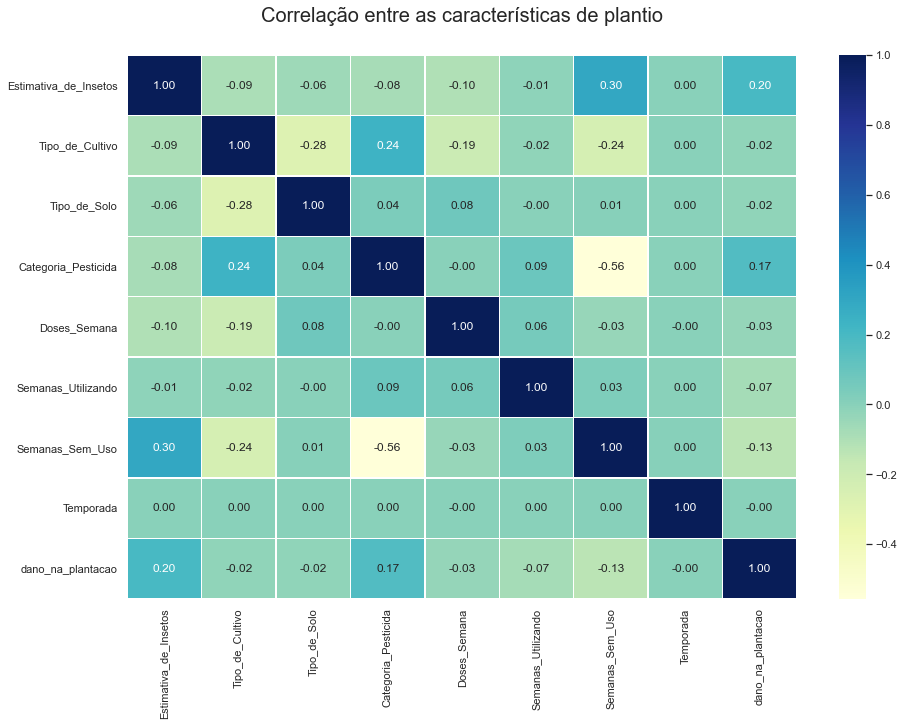

In [255]:
# Visualizando a correlação entre as características de plantio

corr_matrix = Safra_18_19.corr()

fig, ax = plt.subplots(figsize = (15,10))

ax = sns.heatmap(corr_matrix,
                annot      = True,
                linewidths = 0.5,
                fmt        = '.2f',
                cmap       = 'YlGnBu')

plt.title('Correlação entre as características de plantio', 
          size = 20, 
          y    = 1.05);

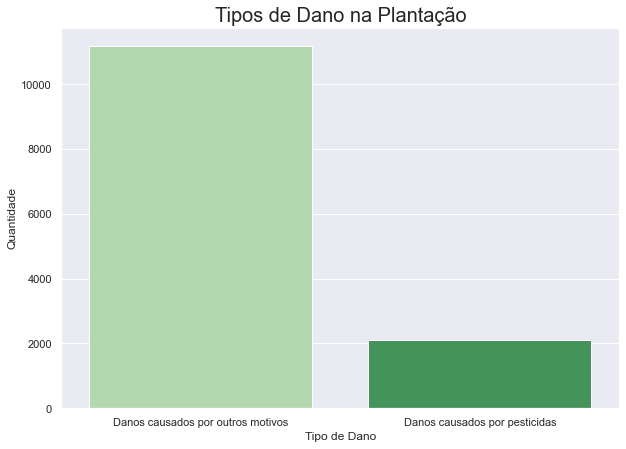

In [256]:
# Visualizando o dano quantitativamente
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,7)})

plot = sns.countplot(palette = 'Greens',
                     x       = Safra_18_19.dano_na_plantacao,
                     order   = [1,2])

plot.set(xlabel = 'Tipo de Dano',
         ylabel = 'Quantidade',
         xticklabels = ['Danos causados por outros motivos', 'Danos causados por pesticidas'])

plt.title('Tipos de Dano na Plantação', size = 20);

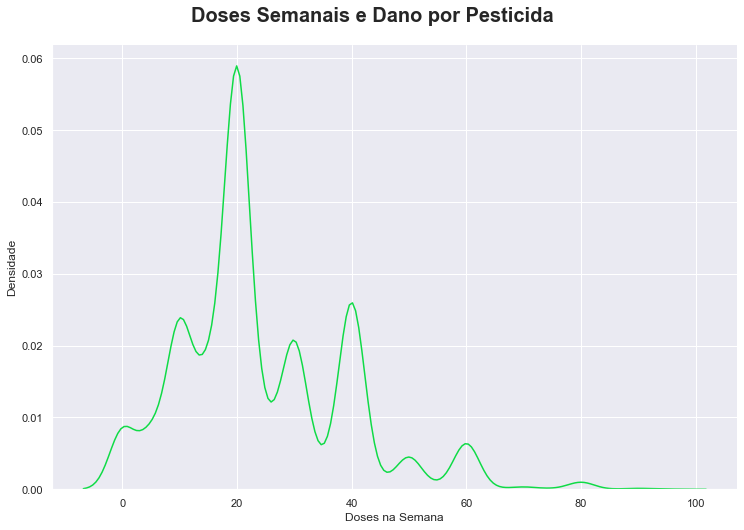

In [178]:
# Visualizando a relação entre Doses por semanas, Dano na Plantação e 
sns.set_style('whitegrid')

plot = sns.displot(Safra_18_19.Doses_Semana[Safra_18_19.dano_na_plantacao == 1], 
                   label  = 'Dano Por Pesticida',
                   color  = '#0fdb46',
                   kind   = 'kde',
                   height = 7,
                   aspect = 1.5)

plot.fig.suptitle('Doses Semanais e Dano por Pesticida',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Doses na Semana',
         ylabel = 'Densidade')

plt.show()

### 3. Limpando e organizando os dados (caso seja necessário)

<br>

Será julgado que é necessário limpar e organizar caso:

<br>

1. O dados não estejam organizados.
2. Tenha dado faltando.
3. Existam dados categóricos.
4. Algum dado esteja no formato errado (ex.: `str`, `int`).

#### 3.1 O dados não estejam organizados.

<br>

Os dados estão organizados corretamente, logo não há a necessidade de mudar isso.

#### 3.2 Tenha dado faltando.

In [161]:
(Safra_18_19.isna().sum()/len(Safra_18_19))*100

Unnamed: 0                   0.00000
Identificador_Agricultor     0.00000
Estimativa_de_Insetos        0.00000
Tipo_de_Cultivo              0.00000
Tipo_de_Solo                 0.00000
Categoria_Pesticida          0.00000
Doses_Semana                 0.00000
Semanas_Utilizando          10.06875
Semanas_Sem_Uso              0.00000
Temporada                    0.00000
dano_na_plantacao            0.00000
dtype: float64

Ok, aproximadamente 10% das Semanas Utilizando estão sem informações, isso se deve provavelmente porque o agricultor não utiliza pesticidas, por isso vamos ver se há a relação de Semanas sem Uso = NaN (sem informação) e Categoria de Pesticida = 0 (nunca usou).

In [195]:
Safra_18_19.Semanas_Utilizando.isna().sum()

8055

In [200]:
len(Safra_18_19[Safra_18_19.Categoria_Pesticida == 1])

763

Como podemos ver, existem mais casos onde as informações das Semanas estão faltando do que a Categoria de Pesticida é 1.

<br>
O que será feito é descobrir quais são as que estão relacionadas a nunca ter usado o pesticida. O resto será colocado a média das Semanas Utilizando.

In [245]:
combined = [Safra_18_19, Safra_20] 

for dataset in combined:
    
    mean = dataset.Semanas_Utilizando.mean()
    
    dataset.Semanas_Utilizando = np.where((dataset.Semanas_Utilizando.isna()) & 
                                              (dataset.Categoria_Pesticida == 1),0, 
                                              mean)

# Checkando a modificação
Safra_20.Semanas_Utilizando.isna().sum()

0

In [205]:
# Checando se ainda há alguma informação faltando
Safra_18_19.isna().sum()

Identificador_Agricultor    0
Estimativa_de_Insetos       0
Tipo_de_Cultivo             0
Tipo_de_Solo                0
Categoria_Pesticida         0
Doses_Semana                0
Semanas_Utilizando          0
Semanas_Sem_Uso             0
Temporada                   0
dano_na_plantacao           0
dtype: int64

#### 3.3 Existam dados categóricos.

<br>

No caso de dados categóricos, é melhor dividir em colunas. Isso será feito em ambas planilhas de 2018-2019 e 2020, uma vez que na hora prever baseado nos dados de 2020, as planilhas precisam estar nos mesmos moldes.

<br><br>

OBS: Dados Categóricos são os que dividem os dados em categorias, no nosso caso, são esses:

<br>

Apesar de ter `dano_na_plantacao` ter característica categórica, ela não será categorizada devido ao fato de ser a variável a ser prevista.

<br><br>

| Variável                 | Descrição                                                    |
| ------------------------ | ------------------------------------------------------------ |
| Tipo_de_Cultivo          | Classificação do tipo de cultivo (0,1)                       |
| Tipo_de_Solo             | Classificação do tipo de solo (0,1)                          |
| Categoria_Pesticida      | Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando) |
| Temporada                | Temporada Climática (1,2,3)                                  |

<br>

In [236]:
'''Por algum motivo a função concat do Pandas não funciona em list comprehensions,
   por isso fiz separadamente'''

dummies_Tipo_de_Cultivo = pd.get_dummies(Safra_18_19.Tipo_de_Cultivo, 
                                         prefix     = 'Tipo_de_Cultivo', 
                                         prefix_sep = '_')

dummies_Tipo_de_Solo = pd.get_dummies(Safra_18_19.Tipo_de_Solo, 
                                      prefix     = 'Tipo_de_Solo', 
                                      prefix_sep = '_')

dummies_Categoria_Pesticida = pd.get_dummies(Safra_18_19.Categoria_Pesticida, 
                                             prefix     = 'Categoria_Pesticida', 
                                             prefix_sep = '_')

dummies_Temporada = pd.get_dummies(Safra_18_19.Temporada,
                                   prefix     = 'Temporada',
                                   prefix_sep = '_')

# Tirando as colunas originais (já que não se fazem mais necessárias)
Safra_18_19.drop('Tipo_de_Cultivo', axis = 1, inplace = True)
Safra_18_19.drop('Tipo_de_Solo', axis = 1, inplace = True)
Safra_18_19.drop('Categoria_Pesticida', axis = 1, inplace = True)
Safra_18_19.drop('Temporada', axis = 1, inplace = True)

# Juntando as novas colunas ao DataFrame
Safra_18_19 = pd.concat([Safra_18_19,
                         dummies_Tipo_de_Cultivo,
                         dummies_Tipo_de_Solo,
                         dummies_Categoria_Pesticida,
                         dummies_Temporada], axis = 1)

In [229]:
dummies_Tipo_de_Cultivo = pd.get_dummies(Safra_20.Tipo_de_Cultivo, 
                                         prefix     = 'Tipo_de_Cultivo', 
                                         prefix_sep = '_')

dummies_Tipo_de_Solo = pd.get_dummies(Safra_20.Tipo_de_Solo, 
                                      prefix     = 'Tipo_de_Solo', 
                                      prefix_sep = '_')

dummies_Categoria_Pesticida = pd.get_dummies(Safra_20.Categoria_Pesticida, 
                                             prefix     = 'Categoria_Pesticida', 
                                             prefix_sep = '_')

dummies_Temporada = pd.get_dummies(Safra_20.Temporada,
                                   prefix     = 'Temporada',
                                   prefix_sep = '_')


# Tirando as colunas originais (já que não se fazem mais necessárias)
Safra_20.drop('Tipo_de_Cultivo', axis = 1, inplace = True)
Safra_20.drop('Tipo_de_Solo', axis = 1, inplace = True)
Safra_20.drop('Categoria_Pesticida', axis = 1, inplace = True)
Safra_20.drop('Temporada', axis = 1, inplace = True)

# Juntando as novas colunas ao DataFrame
Safra_20 = pd.concat([Safra_20,
                         dummies_Tipo_de_Cultivo,
                         dummies_Tipo_de_Solo,
                         dummies_Categoria_Pesticida,
                         dummies_Temporada], axis = 1)

In [230]:
# Checkando as mudanças
Safra_18_19.columns

Index(['Identificador_Agricultor', 'Estimativa_de_Insetos', 'Tipo_de_Cultivo',
       'Tipo_de_Solo', 'Categoria_Pesticida', 'Doses_Semana',
       'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Temporada',
       'Tipo_de_Cultivo_0', 'Tipo_de_Cultivo_1', 'Tipo_de_Solo_0',
       'Tipo_de_Solo_1', 'Categoria_Pesticida_1', 'Categoria_Pesticida_2',
       'Categoria_Pesticida_3', 'Temporada_1', 'Temporada_2', 'Temporada_3'],
      dtype='object')

In [231]:
# Checkando as mudanças
Safra_20.columns

Index(['Identificador_Agricultor', 'Estimativa_de_Insetos', 'Doses_Semana',
       'Semanas_Utilizando', 'Semanas_Sem_Uso'],
      dtype='object')

#### 3.4 Algum dado esteja no formato errado (ex.: `str`, `int`).

In [237]:
Safra_18_19.dtypes

Identificador_Agricultor    object
Estimativa_de_Insetos        int64
Doses_Semana                 int64
Semanas_Utilizando          object
Semanas_Sem_Uso              int64
dano_na_plantacao            int64
Tipo_de_Cultivo_0            uint8
Tipo_de_Cultivo_1            uint8
Tipo_de_Solo_0               uint8
Tipo_de_Solo_1               uint8
Categoria_Pesticida_1        uint8
Categoria_Pesticida_2        uint8
Categoria_Pesticida_3        uint8
Temporada_1                  uint8
Temporada_2                  uint8
Temporada_3                  uint8
dano_na_platacao_0           uint8
dano_na_platacao_1           uint8
dano_na_platacao_2           uint8
dtype: object

In [238]:
Safra_20.dtypes

Identificador_Agricultor    object
Estimativa_de_Insetos        int64
Tipo_de_Cultivo              int64
Tipo_de_Solo                 int64
Categoria_Pesticida          int64
Doses_Semana                 int64
Semanas_Utilizando          object
Semanas_Sem_Uso              int64
Temporada                    int64
dtype: object

Como podemos ver, a coluna `Semanas_Utilizando` está como `object`, ela será mudada.

<br><br>

OBS: Não estou levando em conta a coluna `Identificador_Agricultor` porque ela não será levada em conta no momento da previsão.

In [248]:
# Foi escolhido float devido à existência de valores decimais

combined_drop = [Safra_18_19.drop('Identificador_Agricultor', axis = 1),
                 Safra_20.drop('Identificador_Agricultor', axis = 1)]

for dataset in combined_drop:
    
    for label, content in dataset.items():
        
        if not pd.api.types.is_numeric_dtype(content):
            dataset[label] = pd.Categorical(content).codes
            
# Checando as mudanças
Safra_18_19.dtypes

Identificador_Agricultor     object
Estimativa_de_Insetos         int64
Tipo_de_Cultivo               int64
Tipo_de_Solo                  int64
Categoria_Pesticida           int64
Doses_Semana                  int64
Semanas_Utilizando          float64
Semanas_Sem_Uso               int64
Temporada                     int64
dano_na_plantacao             int64
dtype: object

### 4. Criação do Modelo de Predição